# 1. Object contour detector

## Resumen

Este cuaderno muestra el proceso de localización de objetos llevado a cabo para el proyecto **FruitFlyNet**.

Las trampas empleadas tienen una característica muy especial, su color y el contraste que este hace respecto al resto de elementos que han quedado adheridos a ella. Por lo tanto, en este cuaderno se muestra el método que se llevó a cabo en el TFM de **Miguel Molina-Rotger**, y dirigido por **Bartomeu Alorda**, titulado **"Exploración y caracterización de diferentes estrategias de IA aplicada a trampas IoT para la detección y el conteo de la mosca del olivo"**.

Básicamente, el proceso consiste en:
1. Acotar la imagen a simplemente el interior de la trampa. De esta manera evitamos falsos positivos.
2. Encontrar y recortar todos aquellos contornos que aparecen en la imagen dentro de una medidas razonables.

## Código

### Dependencias

Las versiones empleadas en el cuaderno han sido:
* Python version: 3.11.3
* NumPy version: 1.23.5
* OpenCV version: 4.7.0
* Matplotlib version: 3.7.1

In [1]:
!python --version

Python 3.11.3


In [2]:
import cv2
import numpy
import matplotlib

print("NumPy version:", numpy.__version__)
print("OpenCV version:", cv2.__version__)
print("Matplotlib version:", matplotlib.__version__)

NumPy version: 1.23.5
OpenCV version: 4.7.0
Matplotlib version: 3.7.1


### Librerías

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Funciones

Creamos una función para poder observar imágenes en el propio cuaderno. `cv2.imshow()` crea una ventana a parte.

In [4]:
def show_img_notebook(img):
    # Convertir de BGR a RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Mostrar la imagen
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### Procesado de la imagen

Empezamos importando la imagen de trabajo y observándola.

In [5]:
img_path = r'C:\Users\migue\OneDrive - Universitat de les Illes Balears\Proyectos\ZAP\FruitFlyNet\Files\images\N10_20150828-20151015\pic_Node_10_2015-09-20.jpg'

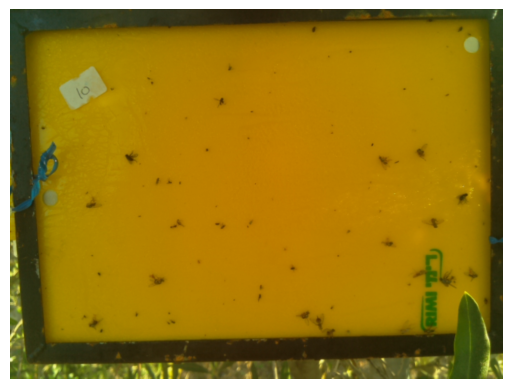

In [6]:
# Seleccionamos imagen y la escalamos al tamaño que se ha trabajado para entrenar
img = cv2.imread(img_path)
img = cv2.resize(img, (0,0), fx=0.7, fy=0.7)

show_img_notebook(img)

Una vez la conocemos, empezamos el procesado. En primer lugar nos centramos en seleccionar solo el interior de la trampa. Esto lo haremos porque sabemos que las moscas solo pueden aparecer en la propia trampa. Por lo tanto, haciendo esta delimitación del área de trabajo, favorecemos el evitar que aparezcan falsos positivos en lugares donde sabemos que no puede aparecer la mosca.

Para esto simplemente buscaremos el contorno amarillo de mayor tamaño en la imagen.

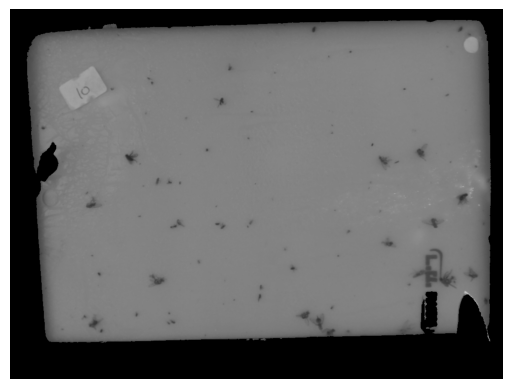

In [7]:
hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
lower_yellow, upper_yellow = np.array([18, 50, 90]), np.array([30, 255, 255])
mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
max_contour = max(contours, key = cv2.contourArea)
mask = np.zeros(img.shape[:2], dtype = 'uint8')
cv2.drawContours(mask, [max_contour], -1, (255), -1)
result = cv2.bitwise_and(img, img, mask=mask)
gray_img = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

show_img_notebook(gray_img)

Una vez disponemos del área de trabajo delimitada, buscamos todos aquellos contornos/elementos que aparecen en la imagen. Llevar a cabo este proceso es interesante gracias al color amarillo tan característico de la propia trampa.

In [8]:
# Buscamos todos los contornos (elementos) que aparecen en la trampa
dst2 = cv2.adaptiveThreshold(gray_img, 50, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
contours, _ = cv2.findContours(dst2, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# Filtramos contornos muy pequeños o muy grandes que claramente no pueden ser mosca
contours = [contour for contour in contours\
    if (cv2.contourArea(contour) > 50)\
    and (cv2.contourArea(contour) < 1000)]

# Para cada contorno obtenemos valores rectangulo que lo contiene y su valor de area
vals = [[cv2.boundingRect(contour),cv2.contourArea(contour)] for contour in contours]

Podemos observar que elementos ha localizado.

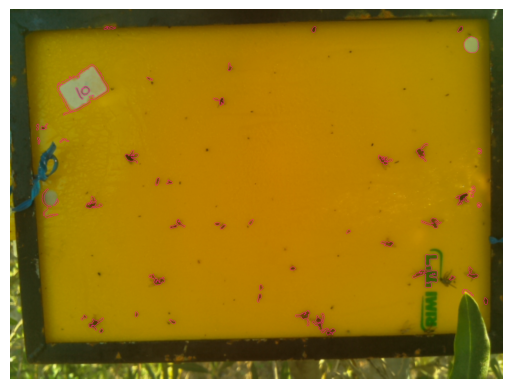

In [9]:
img_copy = img.copy()
cv2.drawContours(img_copy, contours, -1, (147,20,255), 1)
show_img_notebook(img_copy)

Finalmente pasamos a recortar dichos contornos, para que puedan ser clasificados uno a uno.

In [10]:
# Definimos el tamaño de los recortes
W,H = 30,30

In [11]:
# Trabajamos cada contorno para finalmente entender si es o no mosca
img_list = []
for cnt, (box,area) in enumerate(vals):
    # Extraemos diferentes valores del contorno
    #   · Coordenadas de su contenedor (bounding box)
    #   · Coordenadas centroide
    #print('Contorno %d de %d' %(cnt+1, len(vals)))
    # Bounding box
    x,y,w,h = box
    # Centroide
    M = cv2.moments(contours[cnt])
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    # Recortamos la imagen a entender si contiene o no mosca.
    size=int(W/2) # La mitad de W o H
    crop_img = img[cY-size:cY+size, cX-size:cX+size]
    img_list.append(crop_img)

print(f'Se han recortado {len(vals)} contornos/elementos')

Se han recortado 69 contornos/elementos


Al igual que las otras veces podemos observar los resultados.

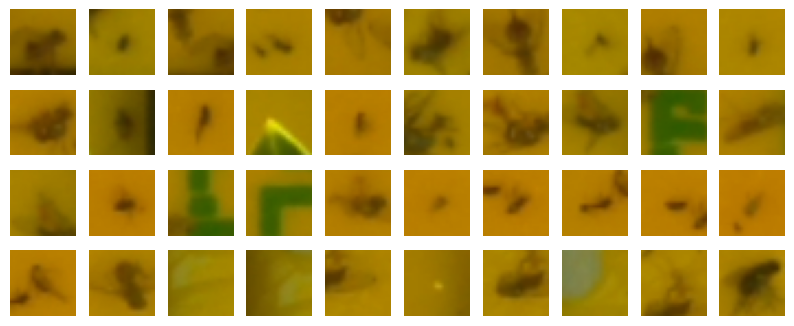

In [12]:
# Definimos número de imágenes a mostrar, tamaño filas y columnas.
n_imgs = 40
img_list_show = img_list[:n_imgs]
n_cols = 10
n_rows = 4

# Crear la figura y los ejes
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 1*n_rows), sharex=True, sharey=True)

# Recorrer las imágenes y mostrarlas en los ejes correspondientes
for i, ax in enumerate(axes.flat):
    # Si hemos mostrado todas las imágenes, salir del bucle
    if i >= n_imgs:
        break
    
    # Mostrar la imagen en el eje correspondiente
    img = cv2.cvtColor(img_list_show[i], cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_axis_off()

# Mostrar la figura
plt.show()